In [1]:
from typing import Dict, Iterable, Optional
# import scvi
import numpy as np
import torch
import pandas as pd
from torch.distributions import Normal, Poisson
from torch.distributions import kl_divergence as kld
from torch import tensor
from complementary_models import HALOMASKVIR as HALOVI
from complementary_models import HALOMASKVAE as HALOVAE
import scanpy as sc
import scvi
import ot
import ot.plot

from matplotlib import pyplot as plt

Global seed set to 0


In [2]:
path = "/mnt/data0/halo/skin/multivelo_hair.h5ad"
adata_multi = sc.read_h5ad(path)
adata_multi.obs["batch_id"] = 1
adata_multi.var["modality"] =adata_multi.var["feature_types"]
adata_mvi = scvi.data.organize_multiome_anndatas(adata_multi)
sc.pp.filter_genes(adata_mvi, min_cells=int(adata_mvi.shape[0] * 0.01))

In [2]:
adata_mvi = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")

In [3]:
HALOVI.setup_anndata(adata_mvi, time_key='latent_time')
model = HALOVI(
    adata_mvi,
    n_genes=(adata_mvi.var['modality']=='Gene Expression').sum(),
    n_regions=(adata_mvi.var['modality']=='Peaks').sum(),
    n_latent=20,
    n_dependent=10
)    

self.w_a :1
yes there is aligner


In [4]:
model = model.load("model_hair_align_causal01_20",adata_mvi)

INFO     File model_hair_align_causal01_20/model.pt already downloaded                       
self.w_a :1
yes there is aligner


In [6]:
latent_expr, latent_acc,latent_expr_dep, latent_atac_dep, latent_expr_indep, latent_atac_indep, times  = model.get_latent_representation()
adata_mvi.obs['latent_time'] = adata_mvi.obs['latent_time'].astype(float)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


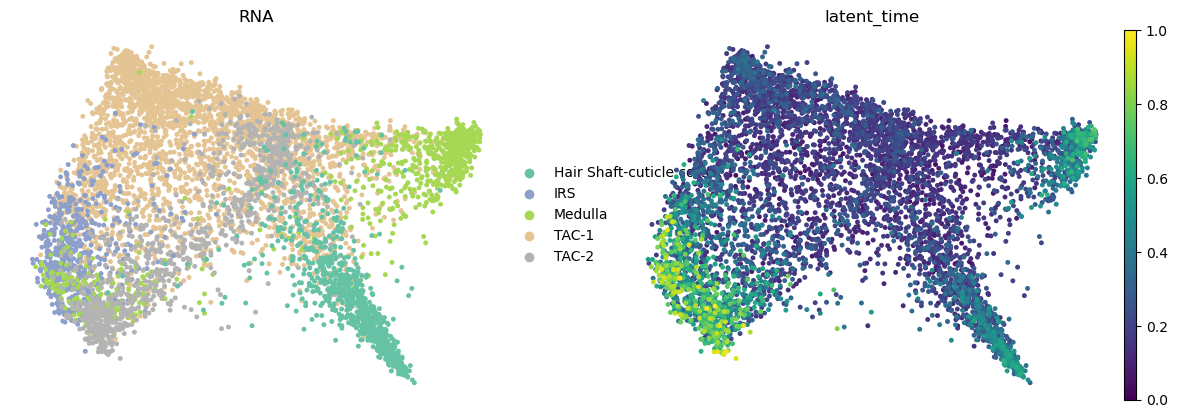

In [7]:
adata_mvi.obsm["latent"] = np.concatenate([latent_expr, latent_acc], axis=1)

sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.01, negative_sample_rate=0.05, spread=10)
sc.pl.umap(adata_mvi, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=['celltype', "latent_time"], title="RNA",palette="Set2")
adata_mvi.obsm["umap_all"] = adata_mvi.obsm["X_umap"] 

In [6]:
for i in range(20):
    adata_mvi.obs["epxr_latent_"+str(i)] = latent_expr[:,i]

for i in range(20):
    adata_mvi.obs["atac_latent_"+str(i)] =  latent_acc[:,i]

In [9]:
adata_mvi.obsm["latent"] = np.concatenate([latent_acc , latent_expr],axis=1)
sc.pp.neighbors(adata_mvi, use_rep = 'latent',n_neighbors=15, metric = 'manhattan')
sc.tl.umap(adata_mvi, min_dist=0.01, negative_sample_rate=0.05, spread=10)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/umap/umap_.py:1356: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


In [12]:
## read paire data
# adata_pair = sc.read_h5ad("data/datasets/mouse_hair_mira_rna_norm.h5ad")
# rna_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired3.h5ad")
rna_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired4.h5ad")
rna_pair.obs = rna_pair.obs.set_index("atac.bc")
from complementary_models import split_rna
adata_pair = split_rna(adata_mvi)
adata_pair.obsm["X_umap"] = adata_mvi.obsm["X_umap"]
adata_pair.layers["peaks"] = rna_pair.layers["peaks"]
adata_pair.var.index =  adata_pair.var.index.map(str.upper)
adata_pair.layers["norm"] = model.get_normalized_expression()
# adata_pair.layers["norm"] =rna_pair.layers["norm"]

In [10]:
adata_pair.obs

celltype  latent_time  batch_id  \
atac.bc                                                                     
R1.01,R2.02,R3.21,P1.08                        IRS     0.218771         1   
R1.01,R2.03,R3.61,P1.06                    Medulla     0.377362         1   
R1.01,R2.06,R3.64,P1.08                      TAC-2     0.120561         1   
R1.01,R2.06,R3.83,P1.07                      TAC-1     0.366586         1   
R1.01,R2.11,R3.86,P1.08                      TAC-1     0.387718         1   
...                                            ...          ...       ...   
R1.96,R2.87,R3.63,P1.07  Hair Shaft-cuticle.cortex     0.475595         1   
R1.96,R2.88,R3.36,P1.05  Hair Shaft-cuticle.cortex     0.436370         1   
R1.96,R2.92,R3.27,P1.06                      TAC-1     0.134454         1   
R1.96,R2.92,R3.28,P1.08                      TAC-2     0.109826         1   
R1.96,R2.92,R3.86,P1.06                      TAC-1     0.126767         1   

                        modality  _scvi_batch  _scvi_labels  chromepot  \
atac.bc                                                                  
R1.01,R2.02,R3.21,P1.08   paired            0             0   0.882226   
R1.01,R2.03,R3.61,P1.06   paired            0             0   0.989017   
R1.01,R2.06,R3.64,P1.08   paired            0             0   0.721477   
R1.01,R2.06,R3.83,P1.07   paired            0             0   0.948828   
R1.01,R2.11,R3.86,P1.08   paired            0             0   0.606843   
...                          ...          ...           ...        ...   
R1.96,R2.87,R3.63,P1.07   paired            0             0   0.658449   
R1.96,R2.88,R3.36,P1.05   paired            0             0   0.906219   
R1.96,R2.92,R3.27,P1.06   paired            0             0   0.502574   
R1.96,R2.92,R3.28,P1.08   paired            0             0   0.439216   
R1.96,R2.92,R3.86,P1.06   paired            0             0   0.908833   

                         epxr_latent_0  epxr_latent_1  epxr_latent_2  ...  \
atac.bc                                                               ...   
R1.01,R2.02,R3.21,P1.08       0.016240      -2.410522      -0.882096  ...   
R1.01,R2.03,R3.61,P1.06       1.058541       0.045746       0.502316  ...   
R1.01,R2.06,R3.64,P1.08       0.766236      -0.551298      -0.745506  ...   
R1.01,R2.06,R3.83,P1.07      -0.363217      -1.367494       0.146944  ...   
R1.01,R2.11,R3.86,P1.08      -0.795754      -1.271072       0.390382  ...   
...                                ...            ...            ...  ...   
R1.96,R2.87,R3.63,P1.07      -0.904160       0.486065      -2.941166  ...   
R1.96,R2.88,R3.36,P1.05      -1.204916       0.206657      -0.837635  ...   
R1.96,R2.92,R3.27,P1.06      -0.066993       0.018305       0.484267  ...   
R1.96,R2.92,R3.28,P1.08      -0.959531       1.017774       0.084126  ...   
R1.96,R2.92,R3.86,P1.06       0.147547       0.788028       0.604362  ...   

                         atac_latent_10  atac_latent_11  atac_latent_12  \
atac.bc                                                                   
R1.01,R2.02,R3.21,P1.08        0.117282        1.516136       -1.163560   
R1.01,R2.03,R3.61,P1.06        2.232173        0.540003       -1.894370   
R1.01,R2.06,R3.64,P1.08       -0.248521       -0.208379       -0.159428   
R1.01,R2.06,R3.83,P1.07       -1.040501       -0.315543        0.514742   
R1.01,R2.11,R3.86,P1.08        1.892752        0.363656       -0.285821   
...                                 ...             ...             ...   
R1.96,R2.87,R3.63,P1.07        2.006178       -0.605090       -0.568420   
R1.96,R2.88,R3.36,P1.05       -0.096773       -0.538511       -0.170339   
R1.96,R2.92,R3.27,P1.06        0.016285        0.015670        2.548180   
R1.96,R2.92,R3.28,P1.08        1.238005        1.507294        0.522074   
R1.96,R2.92,R3.86,P1.06       -0.308041        0.029027        0.681314   

                         atac_latent_13  atac_latent_14  atac_latent_15  \
atac.bc                 

In [24]:
adata_pair = sc.read_h5ad("data/datasets/mouse_hair_rna_paired.h5ad")
adata_pair.obsm["X_umap"] = adata_mvi.obsm["X_umap"]


In [55]:
adata_pair.layers["norm"] = model.get_normalized_expression()

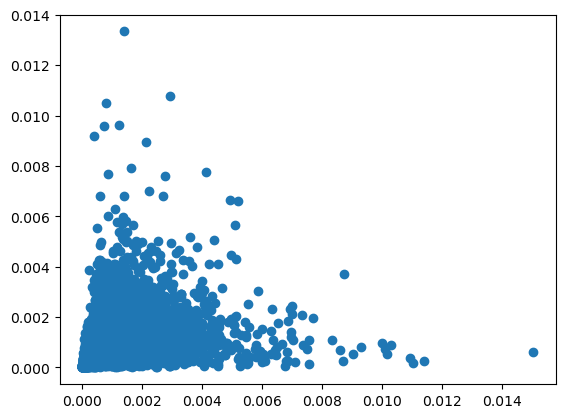

In [102]:
plt.scatter(adata_pair.layers["norm"][:, 801], adata_pair.layers["norm"][:, 800])

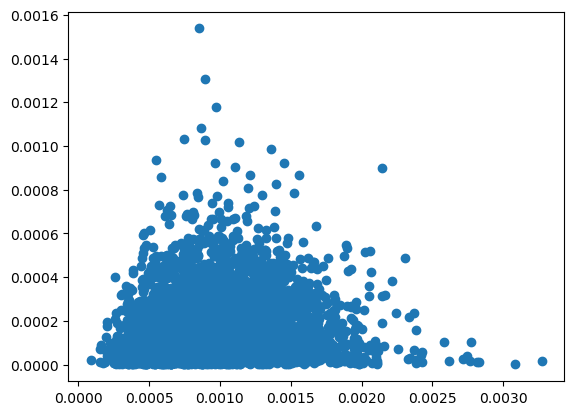

In [37]:
plt.scatter(adata_pair.layers["norm"][:, 7], adata_pair.layers["norm"][:, 810])

In [16]:
def plot_gene_peaks(adata, genename, library_size_atac=1e3, library_size_rna = 1e13, save_RNA=None,  save_Peak=None, vmin=None, vmax=None):
    index_gene = np.where(adata.var.index==genename)[0]
    peaks = adata.layers["peaks"][:, index_gene]
    adata.obs["peak"] = peaks.toarray()*library_size_atac
    adata.obs["gene"] = adata.layers["norm"][:, index_gene] * library_size_rna
    # adata.obs["gene"] = adata.X[:, index_gene].toarray() * library_size_rna


    if save_Peak!=None and save_RNA!=None: 
        with plt.rc_context():
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["gene"], color_map = 'coolwarm', vmin=vmin, vmax=vmax, show=False)
            plt.savefig(save_RNA, dpi=300)
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peak"], color_map = 'coolwarm', vmin=vmin, vmax=vmax, show=False)
            plt.savefig(save_Peak, dpi=300)
    else:
        sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["gene"], color_map = 'coolwarm', vmin=vmin, vmax=vmax)
        # sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peak"], color_map = 'coolwarm', vmin=vmin, vmax=vmax)



EGR3


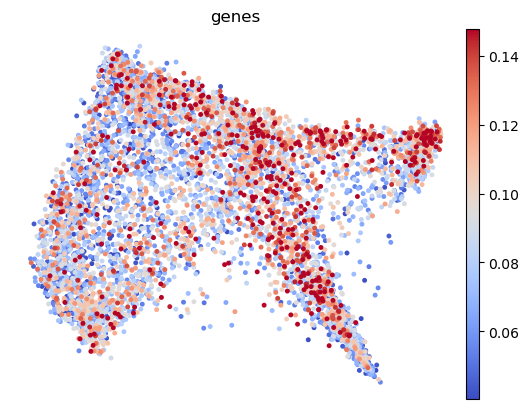

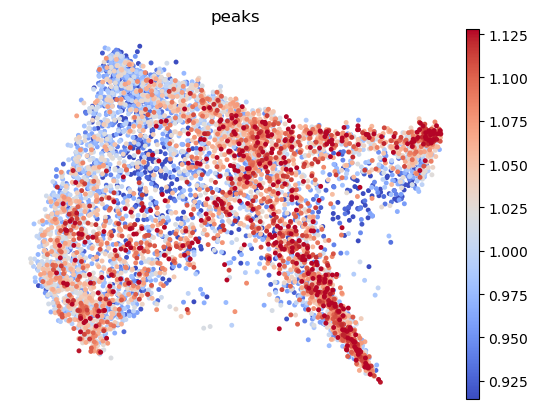

In [191]:
## global SEs
# SEs = [
#     "ACVR1B", "AGPAT3", "GSE1", "BTG2", "DLX3", "DNAJB1", "NOTCH1", "MYO18A", "OVOL1", "CTSC", "MEF2D", 
# "TFAP2A", "PXN", "SAFB", "AZIN1", "LRX2",
#  "MBD2", "ZFAND5", "HTRA1", "DAB2IP", "ATF3", "CTDSP2", "MICAL3"]
# SEs = ["EGF3", "FGFR3", "LGALS3", "TNS1", "SIK1"]
# SEs =["EGR3"]
# for gene in SEs:
#     print(gene)
#     save_RNA = "hair_gene_peak/umap_pair/"+gene+"_RNA.png"
#     save_Peak = "hair_gene_peak/umap_pair/"+gene+"_peaks.png"
#     plot_gene_peaks(adata_pair, gene, save_RNA=save_RNA,save_Peak=save_Peak, vmin="p05", vmax="p95")



WNT3


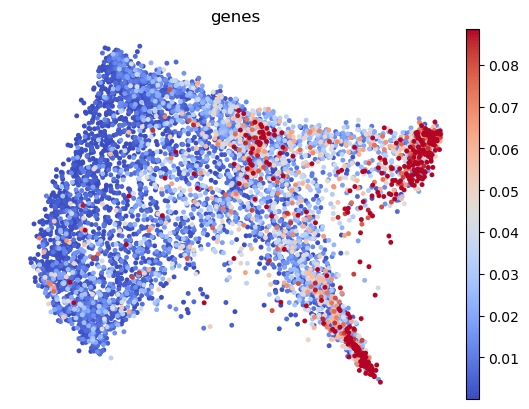

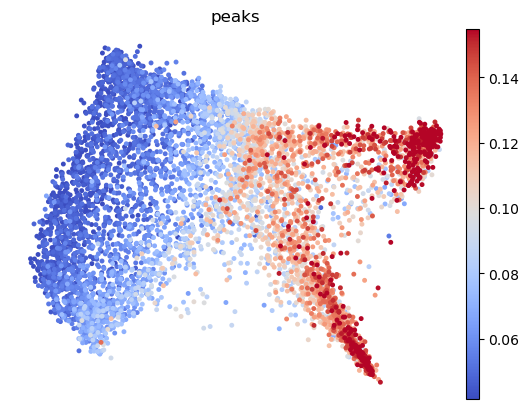

In [186]:
# TF = [
    # "CUX1", "GRHL1", "GATA3", "MAF", "NOTCH1","HOXC13", "LEF1","LRRFIP1",
#  "WNT3"]
# for gene in TF:
#     print(gene)
#     save_RNA = "hair_gene_peak/umap_pair/TFs/"+gene+"_RNA.png"
#     save_Peak = "hair_gene_peak/umap_pair/TFs/"+gene+"_peaks.png"
#     plot_gene_peaks(adata_pair, gene, save_RNA=save_RNA,save_Peak=save_Peak, vmin="p05", vmax="p95")



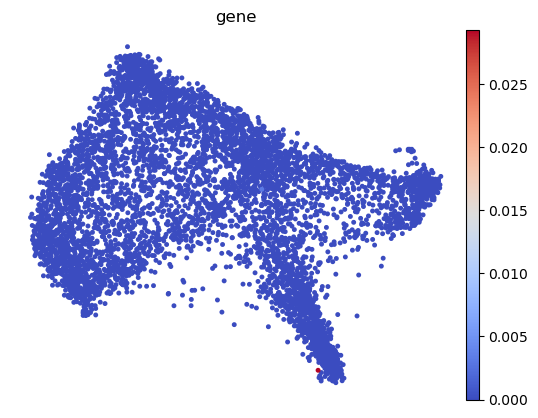

In [20]:
plot_gene_peaks(adata_pair, "LEF1", library_size_atac=1e3, library_size_rna = 1)

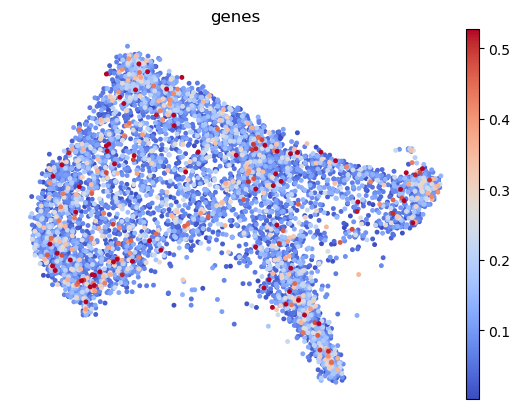

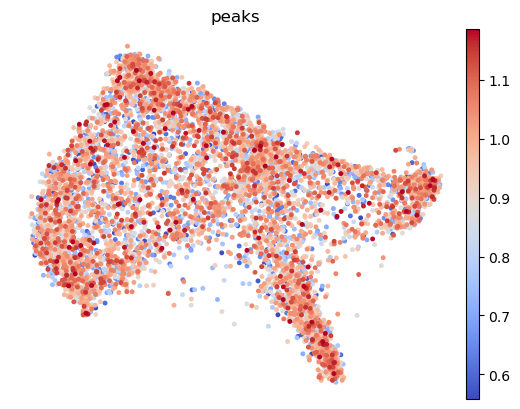

In [19]:
plot_gene_peaks(adata_pair, "GATA3", vmin="p01", vmax="p99")

In [109]:
adata_pair.obs

celltype  latent_time  batch_id  \
atac.bc                                                                     
R1.01,R2.06,R3.83,P1.07                      TAC-1     0.366586         1   
R1.01,R2.11,R3.86,P1.08                      TAC-1     0.387718         1   
R1.01,R2.15,R3.09,P1.07                      TAC-1     0.147633         1   
R1.01,R2.17,R3.81,P1.05                      TAC-1     0.356577         1   
R1.01,R2.18,R3.95,P1.06                      TAC-1     0.131708         1   
...                                            ...          ...       ...   
R1.96,R2.73,R3.72,P1.08  Hair Shaft-cuticle.cortex     0.345225         1   
R1.96,R2.82,R3.52,P1.07  Hair Shaft-cuticle.cortex     0.313259         1   
R1.96,R2.83,R3.68,P1.06  Hair Shaft-cuticle.cortex     0.343906         1   
R1.96,R2.87,R3.63,P1.07  Hair Shaft-cuticle.cortex     0.475595         1   
R1.96,R2.88,R3.36,P1.05  Hair Shaft-cuticle.cortex     0.436370         1   

                        modality  _scvi_batch  _scvi_labels  model_read_scale  \
atac.bc                                                                         
R1.01,R2.06,R3.83,P1.07   paired            0             0          5.254542   
R1.01,R2.11,R3.86,P1.08   paired            0             0          5.859600   
R1.01,R2.15,R3.09,P1.07   paired            0             0          5.147299   
R1.01,R2.17,R3.81,P1.05   paired            0             0          5.057907   
R1.01,R2.18,R3.95,P1.06   paired            0             0          5.345601   
...                          ...          ...           ...               ...   
R1.96,R2.73,R3.72,P1.08   paired            0             0          4.246650   
R1.96,R2.82,R3.52,P1.07   paired            0             0          5.969584   
R1.96,R2.83,R3.68,P1.06   paired            0             0          5.191184   
R1.96,R2.87,R3.63,P1.07   paired            0             0          5.573650   
R1.96,R2.88,R3.36,P1.05   paired            0             0          5.499871   

                          topic_0   topic_1   topic_2  ...  topic_13  \
atac.bc                                                ...             
R1.01,R2.06,R3.83,P1.07  0.053457  0.065765  0.069558  ...  0.037365   
R1.01,R2.11,R3.86,P1.08  0.055307  0.043912  0.045916  ...  0.024248   
R1.01,R2.15,R3.09,P1.07  0.079952  0.184855  0.069613  ...  0.061180   
R1.01,R2.17,R3.81,P1.05  0.053241  0.070957  0.078224  ...  0.038850   
R1.01,R2.18,R3.95,P1.06  0.042768  0.093686  0.114680  ...  0.176798   
...                           ...       ...       ...  ...       ...   
R1.96,R2.73,R3.72,P1.08  0.076270  0.061161  0.053519  ...  0.051342   
R1.96,R2.82,R3.52,P1.07  0.025078  0.021906  0.019646  ...  0.013886   
R1.96,R2.83,R3.68,P1.06  0.044357  0.105621  0.052273  ...  0.055417   
R1.96,R2.87,R3.63,P1.07  0.024213  0.016261  0.012190  ...  0.011257   
R1.96,R2.88,R3.36,P1.05  0.005976  0.009239  0.006391  ...  0.004691   

                         latent_time_cat  latent_time_2  latent_time_10  \
atac.bc                                                                   
R1.01,R2.06,R3.83,P1.07                7             18               3   
R1.01,R2.11,R3.86,P1.08                7             19               3   
R1.01,R2.15,R3.09,P1.07                2              7               1   
R1.01,R2.17,R3.81,P1.05                7             17               3   
R1.01,R2.18,R3.95,P1.06                2              6               1   
...                                  ...            ...             ...   
R1.96,R2.73,R3.72,P1.08                6             17               3   
R1.96,R2.82,R3.52,P1.07                6             15               3   
R1.96,R2.83,R3.68,P1.06                6             17               3   
R1.96,R2.87,R3.63,P1.07                9             23               4   
R1.96,R2.88,R3.36,P1.05                8             21               4   

                         latent_time_3  latent_time_8  latent_time_6  \
a

In [117]:
def label_TAC(adata, library_size_rna = 1e3):
    # index1 = np.where(adata.var.index==genenames[0])[0]
    # index2 = np.where(adata.var.index==genenames[0])[0]
    index = np.where(adata.var.index=="LEF1")[0]
    adata.obs["genes"] = adata.layers["norm"][:, index] * 1e3
    adata.obs["cell_sub_types"] = adata.obs["celltype"]
    adata.obs["cell_sub_types"]  =adata.obs["cell_sub_types"].cat.add_categories(['TAC-HS', "TAC-IRS"])
    adata.obs.loc[(adata.obs.cell_sub_types=="TAC-2")&(adata.obs.genes[0] > 6.5), "cell_sub_types"] = "TAC-HS"
    adata.obs.loc[(adata.obs.cell_sub_types=="TAC-2")&(adata.obs.genes[0] < 6.5), "cell_sub_types"]= "TAC-IRS"
    print(adata.obs[adata.obs.cell_sub_types=="TAC-HS"].shape)
    print(adata.obs[adata.obs.cell_sub_types=="TAC-IRS"].shape)
    


    # index2 = np.where(adata_pair.var.index=="GATA3")[0]
    # adata_pair.obs["genes"] = adata_pair.layers["norm"][:, index2] * 1e3

    # print(adata_pair.obs[(adata_pair.obs.cell_sub_types=="TAC-HS")&(adata_pair.obs.genes[0] > 2.2)].shape)
    # adata_pair.obs.loc[(adata_pair.obs.cell_sub_types=="TAC-HS")&(adata_pair.obs.genes[0] > 2.2), "cell_sub_types"] = "TAC-IRS"

In [116]:
label_TAC(adata_pair, "LEF1")

(0, 30)
(969, 30)
(0, 30)


In [98]:
index2 = np.where(adata_pair.var.index=="GATA3")[0]
adata_pair.obs["genes"] = adata_pair.layers["norm"][:, index] * 1e3
adata_pair.obs.loc[(adata_pair.obs.cell_sub_types=="TAC-HS")&(adata_pair.obs.genes[0] > 2.2), "cell_sub_types"] = "TAC-IRS"


In [104]:
adata_pair.obs[(adata_pair.obs.cell_sub_types=="TAC-HS")].count()

celltype            0
latent_time         0
batch_id            0
modality            0
_scvi_batch         0
_scvi_labels        0
model_read_scale    0
topic_0             0
topic_1             0
topic_2             0
topic_3             0
topic_4             0
topic_5             0
topic_6             0
topic_7             0
topic_8             0
topic_9             0
topic_10            0
topic_11            0
topic_12            0
topic_13            0
latent_time_cat     0
latent_time_2       0
latent_time_10      0
latent_time_3       0
latent_time_8       0
latent_time_6       0
peaks               0
genes               0
cell_sub_types      0
dtype: int64

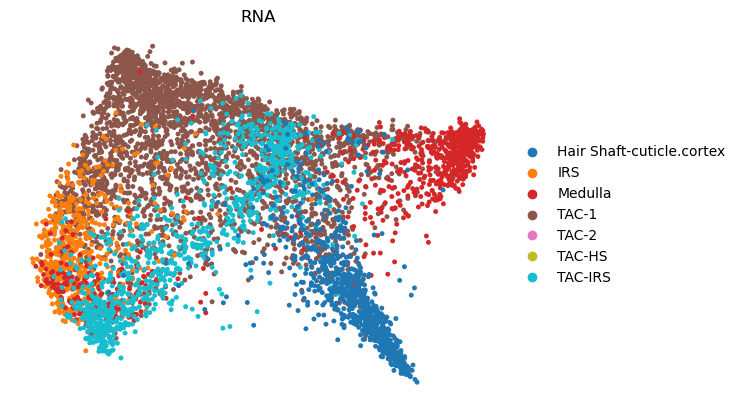

In [103]:
sc.pl.umap(adata_pair, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["cell_sub_types"], title="RNA",palette="tab10")


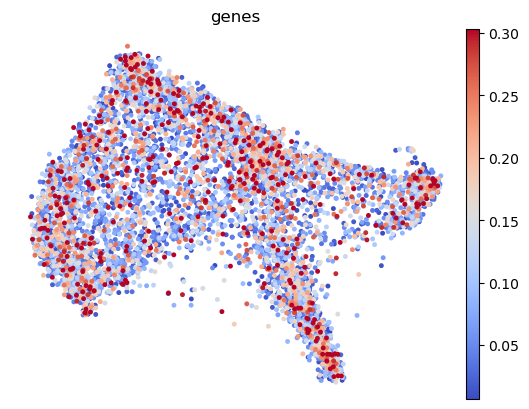

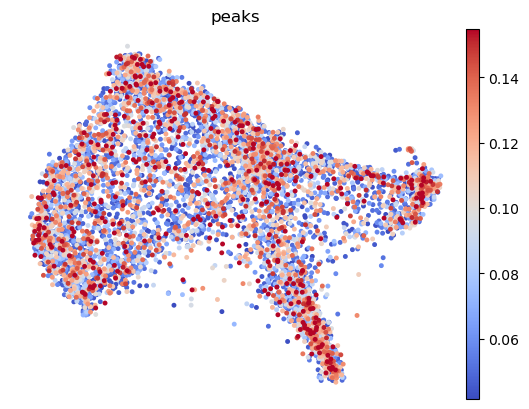

In [62]:
def plot_gene_peaks(adata, genename, library_size_atac=1e3, library_size_rna = 1e2, save_RNA=None,  save_Peak=None, vminR=None, vmaxR=None, vminP=None, vmaxP=None):
    index = np.where(adata.var.index==genename)[0]
    peaks = adata.layers["peaks"][:, index]
    adata.obs["peaks"] = peaks.toarray()*library_size_atac
    adata.obs["genes"] = adata.layers["norm"][:, index] * library_size_rna
    
    if save_Peak!=None and save_RNA!=None: 
        with plt.rc_context():
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["genes"], color_map = 'coolwarm', vmin=vminR, vmax=vmaxR, show=False)
            plt.savefig(save_RNA, dpi=300)
            sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peaks"], color_map = 'coolwarm', vmin=vminP, vmax=vmaxP, show=False)
            plt.savefig(save_Peak, dpi=300)
    else:
        sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["genes"], color_map = 'coolwarm', vmin=vminR, vmax=vmaxR)
        sc.pl.umap(adata, frameon=False, size = 50, alpha = 1, add_outline=False, outline_width=(0.01,0), color=["peaks"], color_map = 'coolwarm', vmin=vminP, vmax=vmaxP)

plot_gene_peaks(adata_pair, "WNT3",vminR="p05", vmaxR="p95", vminP="p05", vmaxP="p95")

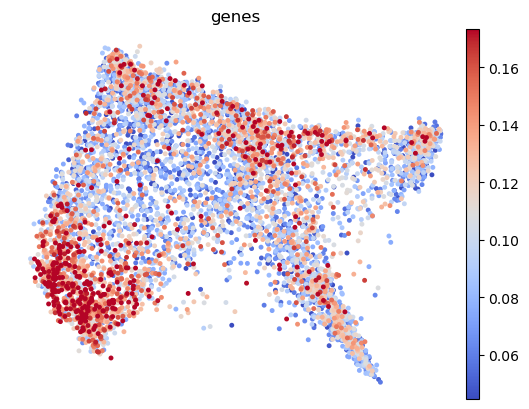

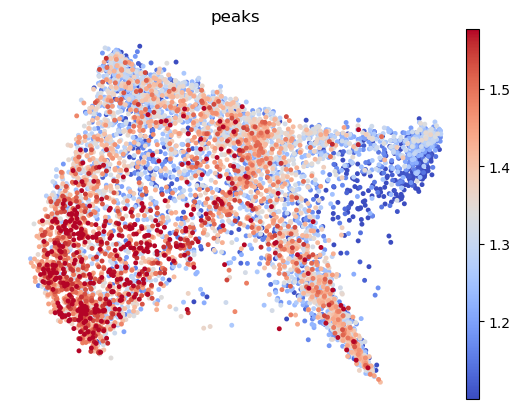

In [212]:
plot_gene_peaks(adata_pair, "DLX3", vmin="p05", vmax="p95", save_Peak="hair_gene_peak/umap_pair/DLX3_peaks.png",  save_RNA="hair_gene_peak/umap_pair/DLX3_RNA.png")

In [48]:
plot_gene_peaks(adata_pair, "DLX3", vmin="p05", vmax="p90")
# plot_gene_peaks(adata_pair, "COL1A1", vmin="p05", vmax="p90")
plot_gene_peaks(adata_pair, "ITGA3", vmin="p05", vmax="p95")
# plot_gene_peaks(adata_pair, "KAT7", vmin="p05", vmax="p95")

[]


IndexError: index 0 is out of bounds for axis 0 with size 0

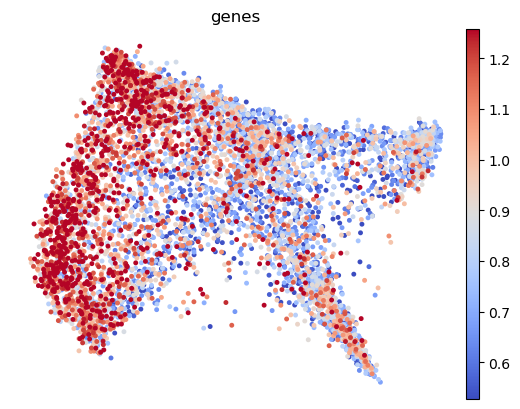

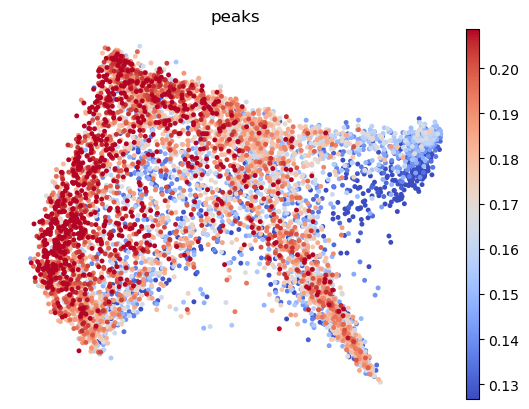

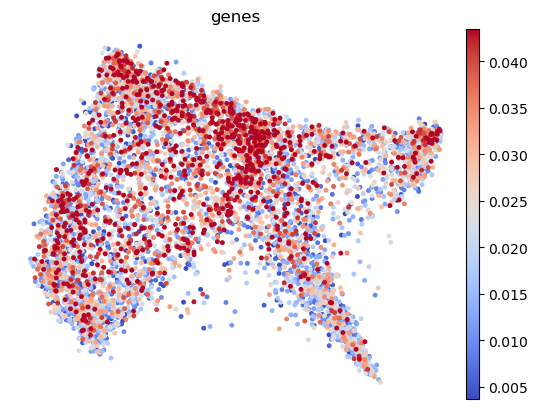

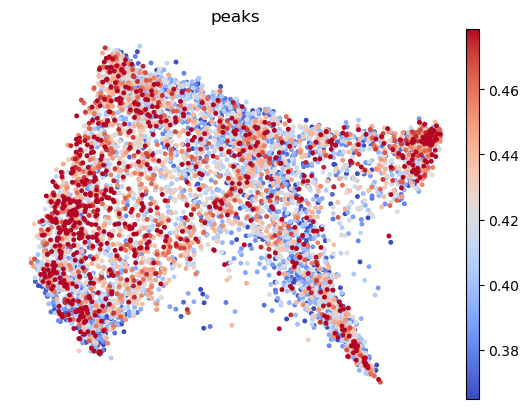

In [215]:
plot_gene_peaks(adata_pair, "CUX1", vmin="p05", vmax="p90")
plot_gene_peaks(adata_pair, "POM121", vmin="p05", vmax="p90")

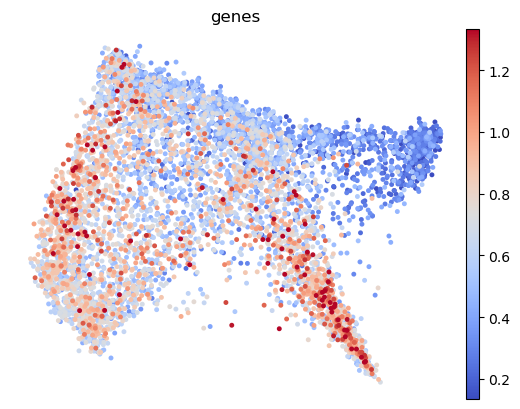

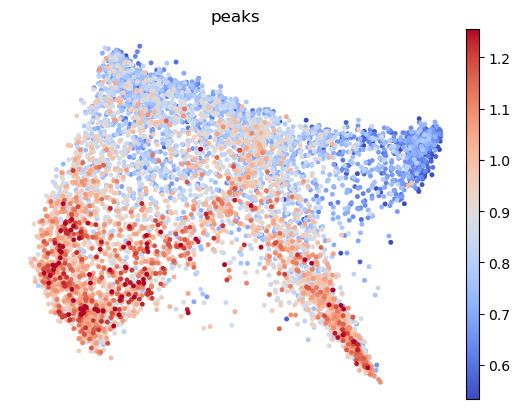

In [88]:
plot_gene_peaks(adata_pair, "NOTCH1", vmin="p01", vmax="p99")

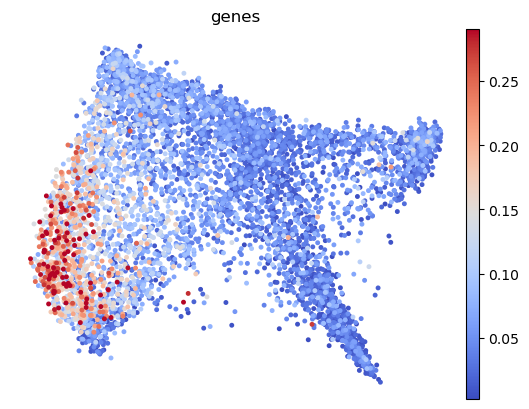

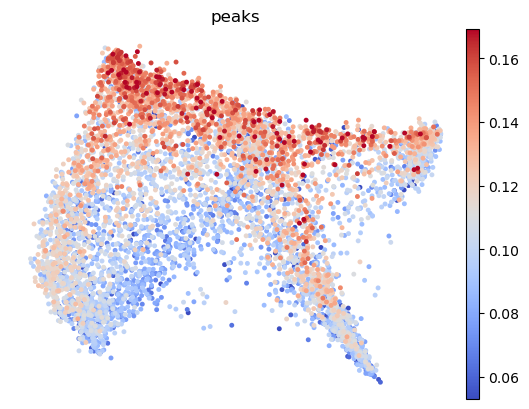

In [90]:
plot_gene_peaks(adata_pair, "CTSC", vmin="p01", vmax="p99")

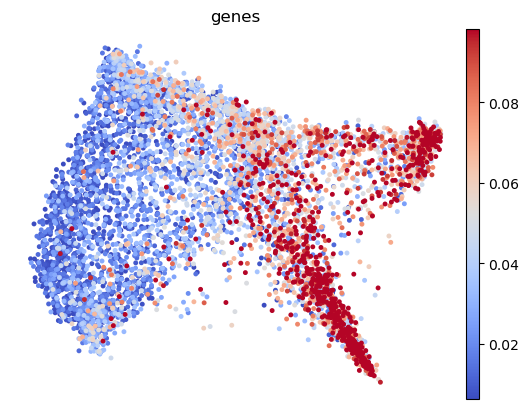

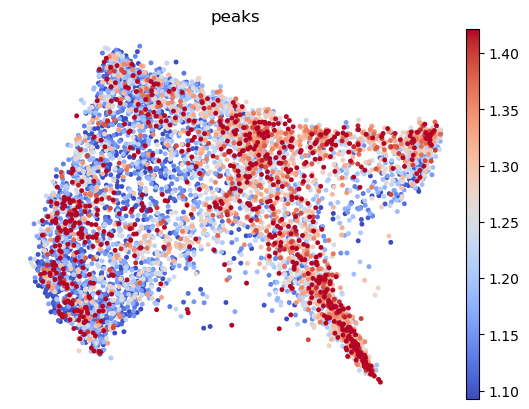

In [210]:
plot_gene_peaks(adata_pair, "HOXC13", vmin = "p10", vmax="p90")

In [204]:
import pandas as pd
adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8)
adata_mvi.obs["latent_time_8"] = adata_mvi.obs["latent_time_8"].apply(lambda x: x.right)
adata_mvi.obs["latent_time_8"]

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


0_paired       0.375
1_paired       0.500
2_paired       0.250
3_paired       0.375
4_paired       0.250
               ...  
6431_paired    0.375
6432_paired    0.375
6433_paired    0.375
6434_paired    0.500
6435_paired    0.500
Name: latent_time_8, Length: 6436, dtype: category
Categories (8, float64): [0.125 < 0.250 < 0.375 < 0.500 < 0.625 < 0.750 < 0.875 < 1.000]

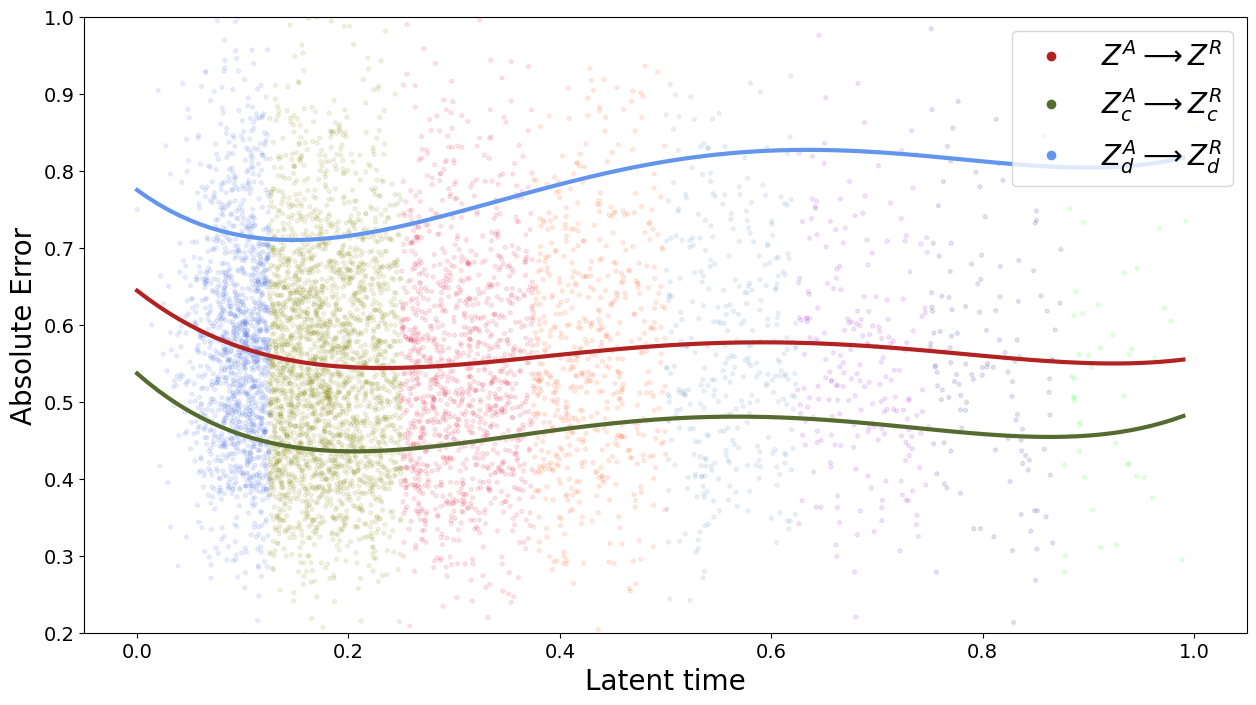

In [209]:
## RNA and atac representation analysis
from numpy.linalg import inv 
from matplotlib.lines import Line2D


colors = ['crimson', 'orangered', 'olive', 'royalblue', 'steelblue', "darkviolet", "navy", "lime"]
# colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', 
#           '#FF7F00', '#FFFF33', '#A65628', '#F781BF']
cell_type = [i for i in adata_mvi.obs["latent_time_8"].unique()]
# cmap = plt.cm.Pastel1  # define the colormap
# colors = [cmap(i) for i in range(8)]
colors = dict(zip(cell_type, colors))


X = latent_acc
Y = latent_expr

b = inv(X.T.dot(X)).dot(X.T).dot(Y)
Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_1 = np.mean(np.abs(Y_Residual),axis=1)



z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_1, 4)
p = np.poly1d(z)



X = latent_atac_dep
Y = latent_expr_dep

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_2 = np.mean(np.abs(Y_Residual),axis=1)

z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_2, 4)
p_1 = np.poly1d(z)



X = latent_atac_indep
Y = latent_expr_indep

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)

z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_3, 4)
p_2 = np.poly1d(z)


X = latent_atac_indep
Y = latent_atac_dep

b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)

z = np.polyfit(adata_mvi.obs['latent_time'], Y_Residual_3, 4)
p_3 = np.poly1d(z)


%matplotlib inline

fig, ax = plt.subplots(figsize=(15,8))

plt.scatter(adata_mvi.obs['latent_time'], Y_Residual_1, color=adata_mvi.obs['latent_time_8'].map(colors),s=8.0, alpha = 0.1)


Times = np.arange(0.0, 1.0, 0.01)
# Times = np.arange(0.0, 8.0, 0.01)

plt.plot(Times, p(Times),color='firebrick', lw=3)
plt.plot(Times, p_1(Times),color='darkolivegreen',lw=3)
plt.plot(Times, p_2(Times),color='cornflowerblue',lw=3)
# plt.plot(Times, p_3(Times),color='goldenrod',lw=3)


ax.set_ylim([0.2, 1.0])

colors = ['firebrick','darkolivegreen','cornflowerblue']
# cell_type = ['$Z^{A}$','$Z^{A}_d$','$Z^{A}_c$']
cell_type = ['$Z^{A} \longrightarrow Z^{R}$','$Z^{A}_{c} \longrightarrow Z^{R}_{c}$','$Z^{A}_{d} \longrightarrow Z^{R}_{d}$', '$Z^{A}_{d} \longrightarrow Z^{A}_{c}$']

plt.tick_params(axis='both', which='major', labelsize=14)  # Increase tick labels font size
plt.xlabel('Latent time', fontsize=20)
plt.ylabel('Absolute Error',fontsize=20)

colors = dict(zip(cell_type, colors))
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
plt.legend(handles=handles, bbox_to_anchor=(1, 1), loc='upper right', fontsize=20)


# plt.title('My title')
# plt.xlabel('Latent time', fontsize=16)
# plt.ylabel('Absolute Error',fontsize=16)
plt.savefig('hair_gene_peak/rep_error.png', dpi=300)
# plt.show()

In [14]:
from causallearn.utils.cit import CIT



# X = latent_acc
# Y = latent_expr

# b = inv(X.T.dot(X)).dot(X.T).dot(Y)
# Yhat = X.dot(b)
# Y_Residual = Yhat - Y
# Y_Residual_1 = np.mean(np.abs(Y_Residual),axis=1)
# KCI_data = np.concatenate([X, Y_Residual], -1)
# X_index = range(latent_acc.shape[1])
# E_index = range(latent_acc.shape[1],latent_acc.shape[1]+Y_Residual.shape[1])
# kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
# pValue = kci_obj(X_index, E_index)
# print("pvalue general: {}".format(pValue))


# X = latent_atac_dep
# Y = latent_expr_dep
T = adata_mvi.obs['latent_time'].to_numpy()
T = np.expand_dims(T, axis=1)
print(T.shape)
# b = inv(X.T.dot(X)).dot(X.T).dot(Y)

# Yhat = X.dot(b)
# Y_Residual = Yhat - Y
# Y_Residual_2 = np.mean(np.abs(Y_Residual),axis=1)

# KCI_data = np.concatenate([X, Y_Residual], -1)
# X_index = range(X.shape[1])
# E_index = range(Y_Residual.shape[1],X.shape[1]+Y_Residual.shape[1])
# kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
# pValue = kci_obj(X_index, E_index)
# print("coupled pvalue: {}".format(pValue))


X = latent_atac_indep
Y = latent_expr_indep
print(X.shape)
b = inv(X.T.dot(X)).dot(X.T).dot(Y)

Yhat = X.dot(b)
Y_Residual = Yhat - Y
Y_Residual_3 = np.mean(np.abs(Y_Residual),axis=1)


KCI_data = np.concatenate([X, Y_Residual, T], -1)
X_index = range(X.shape[1])
E_index = range(X.shape[1],X.shape[1]+Y_Residual.shape[1])
T_index = range(X.shape[1]+Y_Residual.shape[1],X.shape[1]+Y_Residual.shape[1]+1)
kci_obj = CIT(KCI_data, "kci", kernelZ='Gaussian',approx=False, est_width='median')
pValue = kci_obj(X_index, E_index, T_index)
print("decoupled pvalue: {}".format(pValue))

(6436, 1)
(6436, 10)
decoupled pvalue: 0.0


In [7]:
times.shape

(500, 1)

In [32]:
## causal scores
from complementary_models import infer_nonsta_dir
scores_decouple = []


sample_size = 500
round = 20

for i in range(round):

    sample_index = np.random.randint(0, adata_mvi.shape[0], size=sample_size )

    latent_atac_indep_t = latent_atac_indep[sample_index , :]
    latent_expr_indep_t = latent_expr_indep[sample_index, :]
    times_t = times[sample_index, :]
    score3, _, _ = infer_nonsta_dir(latent_atac_indep_t, latent_expr_indep_t, times_t)
    score4, _, _ = infer_nonsta_dir(latent_expr_indep_t, latent_atac_indep_t, times_t)
    score = score3 - score4
    scores_decouple.append(score)
print(scores_decouple)    

[-1.6985459441731798e-08, -2.4285401301060716e-08, -1.84457964180762e-08, -6.049667325425112e-08, -3.8380156275330535e-08, -9.182255168715958e-08, -7.017194607328303e-08, -3.7155085244600095e-08, -1.1198865612627174e-07, -1.232688222468914e-07, -1.3927693734427926e-08, -1.0534941706497047e-07, -1.0259620583652485e-08, -3.5911788681675105e-09, -1.3788365588185414e-09, -1.5079224341407738e-08, -2.1779322498249876e-08, -3.999647743557766e-08, -6.514397037082897e-08, -1.302904069355737e-08]


In [33]:
scores_couple = []


sample_size = 500
round = 20

for i in range(round):

    sample_index = np.random.randint(0, adata_mvi.shape[0], size=sample_size )

    latent_atac_dep_t = latent_atac_dep[sample_index , :]
    latent_expr_dep_t = latent_expr_dep[sample_index, :]
    times_t = times[sample_index, :]
    score3, _, _ = infer_nonsta_dir(latent_atac_dep_t, latent_expr_dep_t, times_t)
    score4, _, _ = infer_nonsta_dir(latent_expr_dep_t, latent_atac_dep_t, times_t)
    score = score3 - score4
    scores_couple.append(score)
print(scores_couple)  

[7.986361358347516e-08, 1.433464374978044e-09, 7.394964884888111e-08, 1.1293039878235156e-08, 1.462779708472084e-08, 6.899748555833085e-08, 1.3403951101831346e-08, 7.339302901532285e-09, 7.157564915760695e-09, 4.905059622362096e-08, 1.300220514588446e-08, 2.5128943828556238e-08, 5.677370297496598e-08, 1.7882523309364906e-08, 1.1609858893701919e-08, 9.853166758888587e-08, 1.193416163669525e-07, 3.31776354167701e-08, 9.050597840620789e-09, 2.1344111922338982e-08]


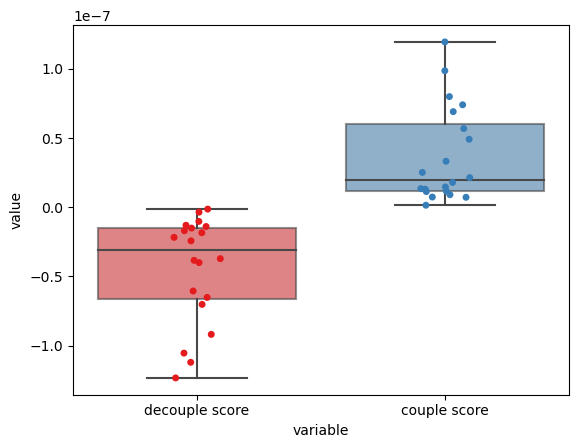

In [37]:
import seaborn as sns
df = pd.DataFrame({"decouple score": scores_decouple, "couple score": scores_couple})
df = df.melt(value_vars=["decouple score", "couple score"])
ax = sns.boxplot(data=df, x="variable", y="value", boxprops={'alpha': 0.6}, palette="Set1")
sns.stripplot(data=df, x="variable", y="value", dodge=True, ax=ax,palette="Set1")
plt.savefig("hair_gene_peak/latent_rep_decouple_score.png", dpi=300)


In [54]:
adata_mvi = sc.read_h5ad("data/datasets/mouse_hair_multi_omics.h5ad")
adata_mvi

AnnData object with n_obs × n_vars = 6436 × 113615
    obs: 'celltype', 'latent_time', 'batch_id', 'modality', '_scvi_batch', '_scvi_labels', 'chromepot', 'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19'
    var: 'feature_types', 'modality', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap'
    obsm: 'X_mvi', 'X_scMVP', 'X_

In [9]:
## OPtimal TRANSPORT 
adata_multi_ini  = adata_mvi[adata_mvi.obs['celltype'].isin( ['TAC-1', 'TAC-2'])].copy()
adata_multi_end = adata_mvi[adata_mvi.obs['celltype'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()

In [83]:
adata_pair.obs = adata_pair.obs.set_index("atac.bc")
adata_mvi.obs["cell_subtypes"] = adata_pair.obs["cell_sub_types"]

In [84]:
adata_mvi.obs

celltype  latent_time  batch_id  \
atac.bc                                                                     
R1.01,R2.02,R3.21,P1.08                        IRS     0.218771         1   
R1.01,R2.03,R3.61,P1.06                    Medulla     0.377362         1   
R1.01,R2.06,R3.64,P1.08                      TAC-2     0.120561         1   
R1.01,R2.06,R3.83,P1.07                      TAC-1     0.366586         1   
R1.01,R2.11,R3.86,P1.08                      TAC-1     0.387718         1   
...                                            ...          ...       ...   
R1.96,R2.87,R3.63,P1.07  Hair Shaft-cuticle.cortex     0.475595         1   
R1.96,R2.88,R3.36,P1.05  Hair Shaft-cuticle.cortex     0.436370         1   
R1.96,R2.92,R3.27,P1.06                      TAC-1     0.134454         1   
R1.96,R2.92,R3.28,P1.08                      TAC-2     0.109826         1   
R1.96,R2.92,R3.86,P1.06                      TAC-1     0.126767         1   

                        modality  _scvi_batch  _scvi_labels  chromepot  \
atac.bc                                                                  
R1.01,R2.02,R3.21,P1.08   paired            0             0   0.882226   
R1.01,R2.03,R3.61,P1.06   paired            0             0   0.989017   
R1.01,R2.06,R3.64,P1.08   paired            0             0   0.721477   
R1.01,R2.06,R3.83,P1.07   paired            0             0   0.948828   
R1.01,R2.11,R3.86,P1.08   paired            0             0   0.606843   
...                          ...          ...           ...        ...   
R1.96,R2.87,R3.63,P1.07   paired            0             0   0.658449   
R1.96,R2.88,R3.36,P1.05   paired            0             0   0.906219   
R1.96,R2.92,R3.27,P1.06   paired            0             0   0.502574   
R1.96,R2.92,R3.28,P1.08   paired            0             0   0.439216   
R1.96,R2.92,R3.86,P1.06   paired            0             0   0.908833   

                         epxr_latent_0  epxr_latent_1  epxr_latent_2  ...  \
atac.bc                                                               ...   
R1.01,R2.02,R3.21,P1.08       0.016240      -2.410522      -0.882096  ...   
R1.01,R2.03,R3.61,P1.06       1.058541       0.045746       0.502316  ...   
R1.01,R2.06,R3.64,P1.08       0.766236      -0.551298      -0.745506  ...   
R1.01,R2.06,R3.83,P1.07      -0.363217      -1.367494       0.146944  ...   
R1.01,R2.11,R3.86,P1.08      -0.795754      -1.271072       0.390382  ...   
...                                ...            ...            ...  ...   
R1.96,R2.87,R3.63,P1.07      -0.904160       0.486065      -2.941166  ...   
R1.96,R2.88,R3.36,P1.05      -1.204916       0.206657      -0.837635  ...   
R1.96,R2.92,R3.27,P1.06      -0.066993       0.018305       0.484267  ...   
R1.96,R2.92,R3.28,P1.08      -0.959531       1.017774       0.084126  ...   
R1.96,R2.92,R3.86,P1.06       0.147547       0.788028       0.604362  ...   

                         atac_latent_11  atac_latent_12  atac_latent_13  \
atac.bc                                                                   
R1.01,R2.02,R3.21,P1.08        1.516136       -1.163560       -0.219881   
R1.01,R2.03,R3.61,P1.06        0.540003       -1.894370       -0.208672   
R1.01,R2.06,R3.64,P1.08       -0.208379       -0.159428        1.993346   
R1.01,R2.06,R3.83,P1.07       -0.315543        0.514742        0.449031   
R1.01,R2.11,R3.86,P1.08        0.363656       -0.285821       -0.562768   
...                                 ...             ...             ...   
R1.96,R2.87,R3.63,P1.07       -0.605090       -0.568420       -0.096550   
R1.96,R2.88,R3.36,P1.05       -0.538511       -0.170339        0.441630   
R1.96,R2.92,R3.27,P1.06        0.015670        2.548180        1.026372   
R1.96,R2.92,R3.28,P1.08        1.507294        0.522074       -0.437498   
R1.96,R2.92,R3.86,P1.06        0.029027        0.681314       -0.277130   

                         atac_latent_14  atac_latent_15  atac_latent_16  \
atac.bc                 

In [72]:
adata_pair.obs

atac.bc                   celltype  latent_time  \
0_paired     R1.01,R2.06,R3.83,P1.07                      TAC-1     0.366586   
1_paired     R1.01,R2.11,R3.86,P1.08                      TAC-1     0.387718   
2_paired     R1.01,R2.15,R3.09,P1.07                      TAC-1     0.147633   
3_paired     R1.01,R2.17,R3.81,P1.05                      TAC-1     0.356577   
4_paired     R1.01,R2.18,R3.95,P1.06                      TAC-1     0.131708   
...                              ...                        ...          ...   
6431_paired  R1.96,R2.73,R3.72,P1.08  Hair Shaft-cuticle.cortex     0.345225   
6432_paired  R1.96,R2.82,R3.52,P1.07  Hair Shaft-cuticle.cortex     0.313259   
6433_paired  R1.96,R2.83,R3.68,P1.06  Hair Shaft-cuticle.cortex     0.343906   
6434_paired  R1.96,R2.87,R3.63,P1.07  Hair Shaft-cuticle.cortex     0.475595   
6435_paired  R1.96,R2.88,R3.36,P1.05  Hair Shaft-cuticle.cortex     0.436370   

             batch_id modality  _scvi_batch  _scvi_labels  model_read_scale  \
0_paired            1   paired            0             0          5.254542   
1_paired            1   paired            0             0          5.859600   
2_paired            1   paired            0             0          5.147299   
3_paired            1   paired            0             0          5.057907   
4_paired            1   paired            0             0          5.345601   
...               ...      ...          ...           ...               ...   
6431_paired         1   paired            0             0          4.246650   
6432_paired         1   paired            0             0          5.969584   
6433_paired         1   paired            0             0          5.191184   
6434_paired         1   paired            0             0          5.573650   
6435_paired         1   paired            0             0          5.499871   

              topic_0   topic_1  ...  topic_13  latent_time_cat  \
0_paired     0.053457  0.065765  ...  0.037365                7   
1_paired     0.055307  0.043912  ...  0.024248                7   
2_paired     0.079952  0.184855  ...  0.061180                2   
3_paired     0.053241  0.070957  ...  0.038850                7   
4_paired     0.042768  0.093686  ...  0.176798                2   
...               ...       ...  ...       ...              ...   
6431_paired  0.076270  0.061161  ...  0.051342                6   
6432_paired  0.025078  0.021906  ...  0.013886                6   
6433_paired  0.044357  0.105621  ...  0.055417                6   
6434_paired  0.024213  0.016261  ...  0.011257                9   
6435_paired  0.005976  0.009239  ...  0.004691                8   

             latent_time_2  latent_time_10  latent_time_3  latent_time_8  \
0_paired                18               3              1              2   
1_paired                19               3              1              3   
2_paired                 7               1              0              1   
3_paired                17               3              1              2   
4_paired                 6               1              0              1   
...                    ...             ...            ...            ...   
6431_paired             17               3              1              2   
6432_paired             15               3              1              2   
6433_paired             17               3              1              2   
6434_paired             23               4              2              3   
6435_paired             21               4              2              3   

             latent_time_6     peaks      genes             cell_sub_types  
0_paired                 2  0.632973   3.060367                      TAC-1  
1_paired                 2  0.658463   5.477180                      TAC-1  
2_paired                 0  0.642426   4.471406                      TAC-1  
3_paired                 2  0.558061   5.844474                      TAC-1  
4_paired        

In [85]:
adata_multi_ini  = adata_mvi[adata_mvi.obs['cell_subtypes'].isin( ['TAC-HS', 'TAC-IRS'])].copy()
adata_multi_end = adata_mvi[adata_mvi.obs['cell_subtypes'].isin(['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex'])].copy()

In [88]:
# Xi = adata_multi_ini.obs[['atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
#                               'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
#                               'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 
#                               'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
#                               'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19',
#  'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 
#  'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19']].to_numpy(dtype='float64')
# Xi = adata_multi_ini.obs[['epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 
# 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_10', 'atac_latent_11', 
#                               'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
#                               'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')
Xi = adata_multi_ini.obs[[
    # 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
    #                           'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
    #                           'atac_latent_8', 'atac_latent_9', 
                              'atac_latent_10', 'atac_latent_11', 
                              'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
                              'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')

# Yi = adata_multi_ini.obs['celltype'].tolist()
Yi = adata_multi_ini.obs['cell_subtypes'].tolist()


umap_i = adata_multi_ini.obsm['X_umap']


# Xf = adata_multi_end.obs[['atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
#                               'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
#                               'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 'atac_latent_11', 
#                               'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
#                               'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19',
#  'epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 'epxr_latent_11', 
#  'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19']].to_numpy(dtype='float64')
Xf = adata_multi_end.obs[[
    # 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 
    #                           'atac_latent_4', 'atac_latent_5', 'atac_latent_6', 'atac_latent_7', 
    #                           'atac_latent_8', 'atac_latent_9', 
                              'atac_latent_10', 'atac_latent_11', 
                              'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15',
                              'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')
# Xf = adata_multi_end.obs[['epxr_latent_10', 'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14',
#  'epxr_latent_15', 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19' ,'atac_latent_10', 'atac_latent_11', 
#                               'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
#                               'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']].to_numpy(dtype='float64')
Yf = adata_multi_end.obs['cell_subtypes'].tolist()

umap_f = adata_multi_end.obsm['X_umap']

In [11]:
adata_multi_end.obs.celltype.unique()

['IRS', 'Medulla', 'Hair Shaft-cuticle.cortex']
Categories (3, object): ['Hair Shaft-cuticle.cortex', 'IRS', 'Medulla']

In [61]:
adata_multi_end.obs["cell_subtypes"]

Series([], Name: cell_subtypes, dtype: category
Categories (0, object): [])

In [58]:
n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac1

0

In [92]:
n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.cell_subtypes=="TAC-HS"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.cell_subtypes=="TAC-IRS"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs.loc[adata_multi_ini.obs.cell_subtypes=="TAC-HS", "prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs.loc[adata_multi_ini.obs.cell_subtypes=="TAC-IRS", "prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.cell_subtypes=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.cell_subtypes=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.cell_subtypes=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs.loc[adata_multi_end.obs.cell_subtypes=="IRS", "prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs.loc[adata_multi_end.obs.cell_subtypes=="Medulla", "prob"]= n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs.loc[adata_multi_end.obs.cell_subtypes=="Hair Shaft-cuticle.cortex", "prob"]= n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()

M = ot.dist(Xi, Xf,metric = 'sqeuclidean')

In [90]:
n1 = len(Xi)
n2 = len(Xf)

n_tac1 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
n_tac2 = adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"].count()[0]
adata_multi_ini.obs["prob"] = 0

adata_multi_ini.obs.loc[adata_multi_ini.obs.celltype=="TAC-1", "prob"] = n_tac1 / (n_tac1 + n_tac2)
adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)


n_irs = adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"].count()[0]
n_med = adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"].count()[0]
n_cort = adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"].count()[0]

adata_multi_end.obs["prob"] = 0

adata_multi_end.obs[adata_multi_end.obs.celltype=="IRS"]["prob"] = n_irs / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Medulla"]["prob"] = n_med / (n_irs + n_med+ n_cort)
adata_multi_end.obs[adata_multi_end.obs.celltype=="Hair Shaft-cuticle.cortex"]["prob"] = n_cort / (n_irs + n_med+ n_cort)


a = adata_multi_ini.obs["prob"].to_list()
b = adata_multi_end.obs["prob"].to_list()


# a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2  # uniform distribution on samples

M = ot.dist(Xi, Xf,metric = 'sqeuclidean')

/tmp/ipykernel_8551/898157017.py:8: RuntimeWarning: invalid value encountered in long_scalars
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-1"]["prob"] = n_tac1 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:9: RuntimeWarning: invalid value encountered in long_scalars
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_multi_ini.obs[adata_multi_ini.obs.celltype=="TAC-2"]["prob"] = n_tac2 / (n_tac1 + n_tac2)
/tmp/ipykernel_8551/898157017.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [96]:
lambd = 0.1
# lambd = 4e-1

Gs = ot.sinkhorn(a, b, M, lambd)

/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:484: RuntimeWarning: overflow encountered in true_divide
  v = b / KtransposeU
/home/haiyi/anaconda3/envs/halo/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 191
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


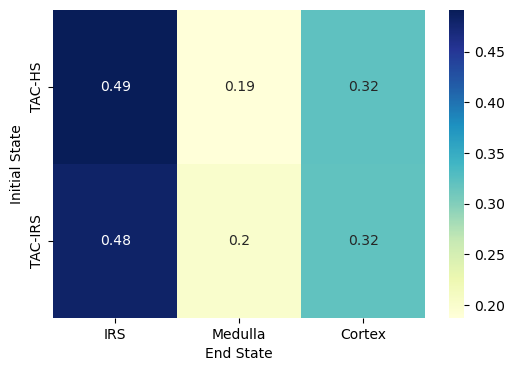

<Figure size 640x480 with 0 Axes>

In [97]:
import seaborn as sns
prob_matrix = Gs

row_groups = np.array(Yi)  
column_groups = np.array(Yf)


row_group = np.unique(row_groups)
col_group = np.unique(column_groups)
num_row_groups = row_group.size
num_col_groups = col_group.size


agg_matrix = np.zeros((num_row_groups, num_col_groups))



# Aggregate probabilities
for i, rg in enumerate(row_group):
    for j, cg in enumerate(col_group):
        row_indices = np.where(row_groups == rg)[0]
        col_indices = [index for index, val in enumerate(column_groups) if val == cg]
        
        cell_sum = 0
        for ri in row_indices:
            for ci in col_indices:
#                 if ri < prob_matrix.shape[0] and ci < prob_matrix.shape[1]:
                    cell_sum += prob_matrix[ri, ci]
        
        # Assign the sum to the aggregated matrix cell
        agg_matrix[i, j] = cell_sum


## aggregate  

# Display the aggregated matrix



row_sums = agg_matrix.sum(axis=1, keepdims=True)
normalized_matrix = agg_matrix / row_sums

## normalize by column
# col_sums = agg_matrix.sum(axis=0, keepdims=True)
# normalized_matrix = agg_matrix / col_sums


normalized_matrix

row_names = ['TAC-HS', 'TAC-IRS']
column_names = ['IRS', 'Medulla', 'Cortex']

# Visualize the row-normalized probability matrix with row names and column names
plt.figure(figsize=(6, 4))
sns.heatmap(normalized_matrix, annot=True, cmap='YlGnBu', 
            cbar=True, xticklabels=column_names, yticklabels=row_names)
# plt.title('Heatmap of Row-Normalized Probability Matrix with Row and Column Names')
plt.ylabel('Initial State')
plt.xlabel('End State')
plt.show()
plt.savefig("figs/Hair/20_aligned/OT.pdf", dpi=300)

In [128]:
def plot2D_samples_mat(xs, xt, G, thr=1e-8,color =[.5, .5, 1] ):
    r""" Plot matrix :math:`\mathbf{G}` in 2D with lines using alpha values

    Plot lines between source and target 2D samples with a color
    proportional to the value of the matrix :math:`\mathbf{G}` between samples.


    Parameters
    ----------
    xs : ndarray, shape (ns,2)
        Source samples positions
    b : ndarray, shape (nt,2)
        Target samples positions
    G : ndarray, shape (na,nb)
        OT matrix
    thr : float, optional
        threshold above which the line is drawn
    **kwargs : dict
        parameters given to the plot functions (default color is black if
        nothing given)
    """

#     if ('color' not in kwargs) and ('c' not in kwargs):
#         kwargs['color'] = 'k'
    mx = G.max()
#     if 'alpha' in kwargs:
#         scale = kwargs['alpha']
#         del kwargs['alpha']
#     else:
#         scale = 1
    for i in range(xs.shape[0]):
        for j in range(xt.shape[0]):
            if G[i, j] / mx > thr:
                plt.plot([xs[i, 0], xt[j, 0]], [xs[i, 1], xt[j, 1]],
                        alpha=0.05,c = color)
                plt.arrow(xs[i, 0], xt[j, 0], xs[i, 1]-xs[i, 0], xt[j, 1]-xt[j, 0],
                        alpha=0.01)        

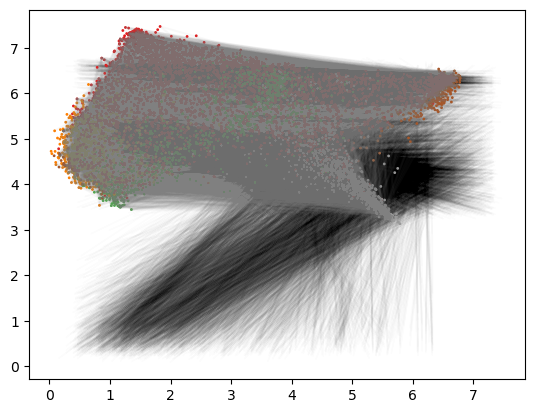

In [129]:
color_set =  {'TAC-1' : '#e41a1c', 'TAC-2' : '#4daf4a', 'IRS':'#ff7f00','Medulla' : '#a65628','Hair Shaft-cuticle.cortex':'#999999'}


plt.figure(8)
plot2D_samples_mat(umap_i, umap_f, Gs, 
                           color='grey', thr=np.percentile(Gs,99.999))
plt.scatter(umap_i[:,0], umap_i[:,1], c=[color_set[x] for x in Yi],s=1)
plt.scatter(umap_f[:,0], umap_f[:,1], c=[color_set[x] for x in Yf],s=1)
plt.show()


In [29]:
from sklearn.model_selection import train_test_split
sub_i, _, label_i, _ = train_test_split(np.concatenate((Xi,umap_i),axis=1), Yi, test_size=0.05, stratify=Yi, random_state=42)
sub_f, _, label_f, _ = train_test_split(np.concatenate((Xf,umap_f),axis=1), Yf, test_size=0.05, stratify=Yf, random_state=42)
latent_num = 20
Xi_sub = sub_i[:,:latent_num]
umap_i_sub = sub_i[:,latent_num:latent_num+2]

Xi_sub = sub_i[:,:latent_num]
umap_i_sub = sub_i[:,latent_num:latent_num+2]

print(Xi_sub.shape)
Xf_sub = sub_f[:,:latent_num]
umap_f_sub = sub_f[:,latent_num:latent_num+2]

n1 = len(Xi_sub)
n2 = len(Xf_sub)
a, b = np.ones((n1,)) / n1, np.ones((n2,)) / n2  # uniform distribution on samples

M = ot.dist(Xi_sub, Xf_sub,metric = 'sqeuclidean')

(3795, 20)


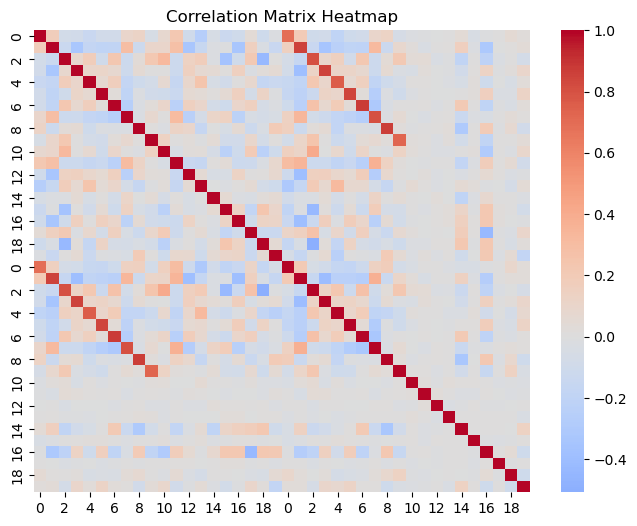

In [8]:
## Benchmark on correlation matrix 
import seaborn as sns
df_A = pd.DataFrame(latent_expr)
df_B = pd.DataFrame(latent_acc)
df_combined = pd.concat([df_A, df_B], axis=1)
correlation_matrix = df_combined.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", center=0.0)
plt.title('Correlation Matrix Heatmap')
# plt.savefig("figs/Hair/20_aligned/mouse_latent_corr.png", dpi=300)
plt.show()

In [18]:
# correlation_matrix = correlation_matrix.to_numpy()
correlation_matrix = np.abs(correlation_matrix)
coupled_corr = correlation_matrix[20:30, :10].ravel()
decouple_corr = correlation_matrix[30:, 10:20].ravel()
lower_triangular_matrix = np.tril(correlation_matrix, k=-1)
lower_diagonal_values = lower_triangular_matrix[lower_triangular_matrix != 0]
rna_corr = correlation_matrix[:20, :20]
rna_corr = rna_corr[ np.tril(rna_corr, k=-1) != 0]
atac_corr = correlation_matrix[20:, 20:]
atac_corr = atac_corr[ np.tril(atac_corr, k=-1) != 0]

{'whiskers': [<matplotlib.lines.Line2D at 0x7fdb323ed670>,
 'caps': [<matplotlib.lines.Line2D at 0x7fdb323edc10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fdb323e3220>],
 'medians': [<matplotlib.lines.Line2D at 0x7fdb323f91f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fdb323f94c0>],
 'means': []}

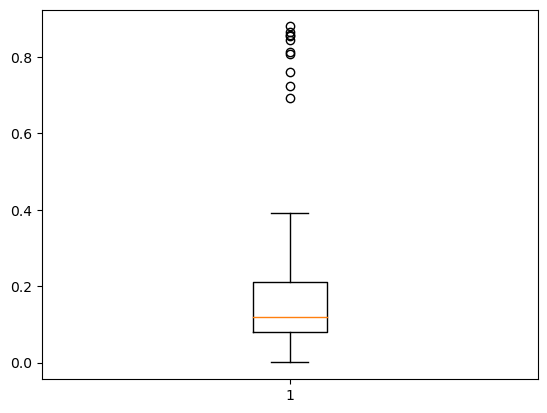

In [24]:
plt.boxplot(correlation_matrix[20:30, :10].ravel())

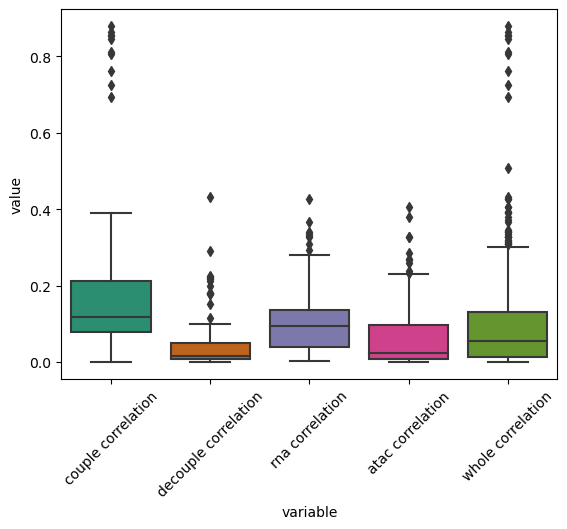

In [25]:
df_rep1 = pd.DataFrame({"couple correlation": coupled_corr, "decouple correlation": decouple_corr})
df_rep1 = df_rep1.melt()
df_rep2 = pd.DataFrame({"rna correlation": rna_corr, "atac correlation": atac_corr})
df_rep2 = df_rep2.melt()
df_rep3 = pd.DataFrame({"variable": "whole correlation", "value": lower_diagonal_values})
df = pd.concat([df_rep1, df_rep2, df_rep3], axis=0)
# palette = sns.color_palette("Dark2", n_colors=len(df.columns))
ax = sns.boxplot(x='variable', y='value', data=df, palette="Dark2")
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))  # Set alpha to 0.3 for transparency

#     print(artist)
#     col = palette[i % len(palette)]
#     artist.set_edgecolor(col)

    # Also set the color for the whiskers, caps, and medians
    # for j in range(i*6, i*6+6):
    #     line = ax.lines[j]
    #     line.set_color(col)
    #     line.set_mfc(col)
    #     line.set_mec(col)

    # for j in range(len(ax.lines)):
    #     if j % 6 == 4:  # Median lines are every 6th line starting from index 4
    #         ax.lines[j].set_color('red')

plt.xticks(rotation=45)
plt.savefig("corr_halo_hair.pdf", dpi=300)


In [206]:
df.to_csv("hair_correlation_halo.csv")

6


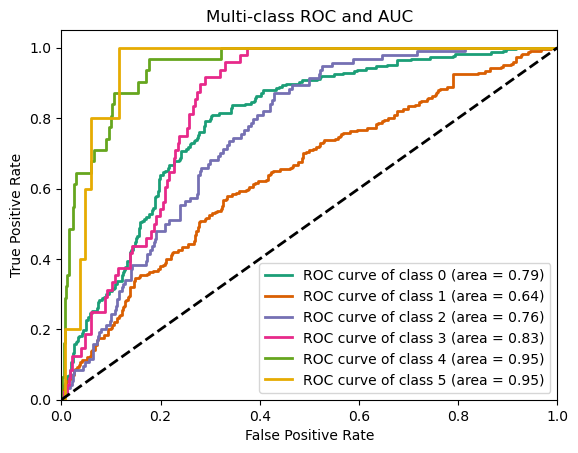

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc


X = adata_mvi.obs[['epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 
'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 
'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15',
 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 
 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 
 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 
'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']]
# adata_mvi.obs["latent_time_50"] = pd.cut(adata_mvi.obs['latent_time'], 50, labels=[i for i in range(50)])
# adata_mvi.obs["latent_time_10"] = pd.cut(adata_mvi.obs['latent_time'], 10, labels=[i for i in range(10)])
# adata_mvi.obs["latent_time_5"] = pd.cut(adata_mvi.obs['latent_time'], 5, labels=[i for i in range(5)])
# adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
# adata_mvi.obs["latent_time_6"] = pd.cut(adata_mvi.obs['latent_time'], 6, labels=[str(i) for i in range(6)])
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "rna_atac_halo"})
plt.savefig("figs/Hair/20_aligned/expr_atac_roc.pdf", dpi=300)


In [30]:
roc_df

fpr  \
0  [0.0, 0.0, 0.0023923444976076554, 0.0023923444...   
1  [0.0, 0.0024752475247524753, 0.002475247524752...   
2  [0.0, 0.0018181818181818182, 0.003636363636363...   
3  [0.0, 0.0016778523489932886, 0.003355704697986...   
4  [0.0, 0.0, 0.0016313213703099511, 0.0016313213...   
5  [0.0, 0.001564945226917058, 0.0078247261345852...   

                                                 tpr   roc_auc        methods  
0  [0.0, 0.004424778761061947, 0.0044247787610619...  0.790299  rna_atac_halo  
1  [0.0, 0.0, 0.029166666666666667, 0.02916666666...  0.642915  rna_atac_halo  
2  [0.0, 0.0, 0.0, 0.02127659574468085, 0.0212765...  0.755919  rna_atac_halo  
3  [0.0, 0.0, 0.0, 0.020833333333333332, 0.020833...  0.831900  rna_atac_halo  
4  [0.0, 0.03225806451612903, 0.03225806451612903...  0.945535  rna_atac_halo  
5  [0.0, 0.0, 0.0, 0.2, 0.2, 0.4, 0.4, 0.6, 0.6, ...  0.946166  rna_atac_halo

6


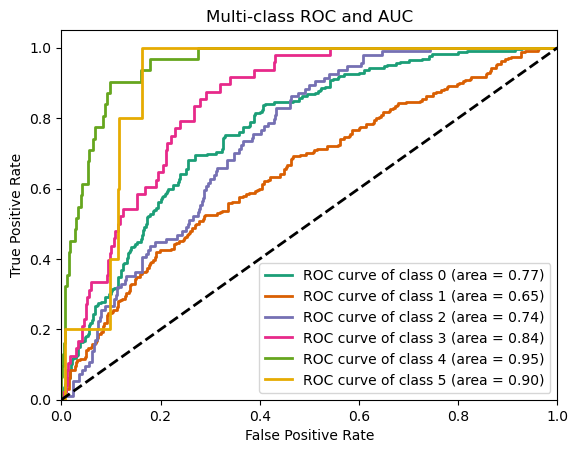

In [31]:
X = adata_mvi.obs[['epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 
'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9', 'epxr_latent_10', 
'epxr_latent_11', 'epxr_latent_12', 'epxr_latent_13', 'epxr_latent_14', 'epxr_latent_15',
 'epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19']]
# adata_mvi.obs["latent_time_50"] = pd.cut(adata_mvi.obs['latent_time'], 50, labels=[i for i in range(50)])
# adata_mvi.obs["latent_time_10"] = pd.cut(adata_mvi.obs['latent_time'], 10, labels=[i for i in range(10)])
# adata_mvi.obs["latent_time_5"] = pd.cut(adata_mvi.obs['latent_time'], 5, labels=[i for i in range(5)])
# adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
# adata_mvi.obs["latent_time_6"] = pd.cut(adata_mvi.obs['latent_time'], 6, labels=[str(i) for i in range(6)])
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df_temp = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "rna_halo"})
roc_df = pd.concat([roc_df, roc_df_temp], axis=0)
plt.savefig("figs/Hair/20_aligned/expr_roc.pdf", dpi=300)

6


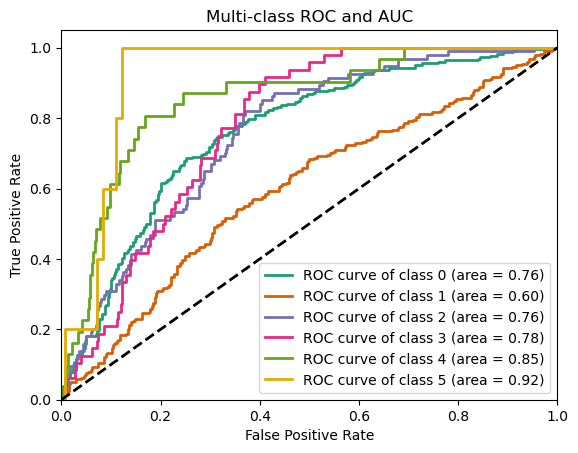

In [32]:
X = adata_mvi.obs[[ 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 
 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9', 'atac_latent_10', 
'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']]
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df_temp = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "atac_halo"})
roc_df = pd.concat([roc_df, roc_df_temp], axis=0)
plt.savefig("figs/Hair/20_aligned/atac_roc.pdf", dpi=300)

6


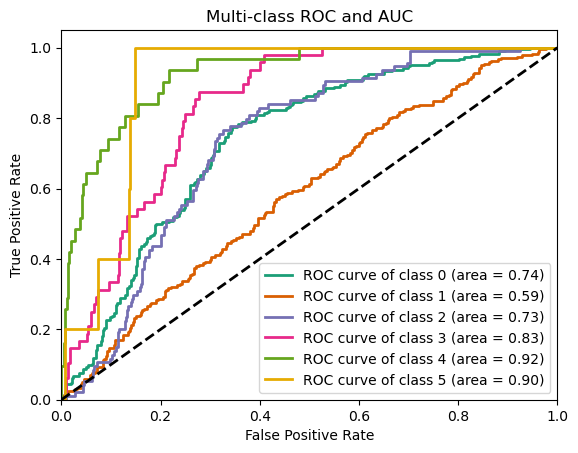

In [33]:
X = adata_mvi.obs[['epxr_latent_15','epxr_latent_16', 'epxr_latent_17', 'epxr_latent_18', 'epxr_latent_19', 'atac_latent_10', 
'atac_latent_11', 'atac_latent_12', 'atac_latent_13', 'atac_latent_14', 'atac_latent_15', 
'atac_latent_16', 'atac_latent_17', 'atac_latent_18', 'atac_latent_19']]
# adata_mvi.obs["latent_time_50"] = pd.cut(adata_mvi.obs['latent_time'], 50, labels=[i for i in range(50)])
# adata_mvi.obs["latent_time_10"] = pd.cut(adata_mvi.obs['latent_time'], 10, labels=[i for i in range(10)])
# adata_mvi.obs["latent_time_5"] = pd.cut(adata_mvi.obs['latent_time'], 5, labels=[i for i in range(5)])
# adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
# adata_mvi.obs["latent_time_6"] = pd.cut(adata_mvi.obs['latent_time'], 6, labels=[str(i) for i in range(6)])
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df_temp = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "decouple_halo"})
roc_df = pd.concat([roc_df, roc_df_temp], axis=0)
plt.savefig("figs/Hair/20_aligned/expr_atac_decouple_roc.pdf", dpi=300)

6


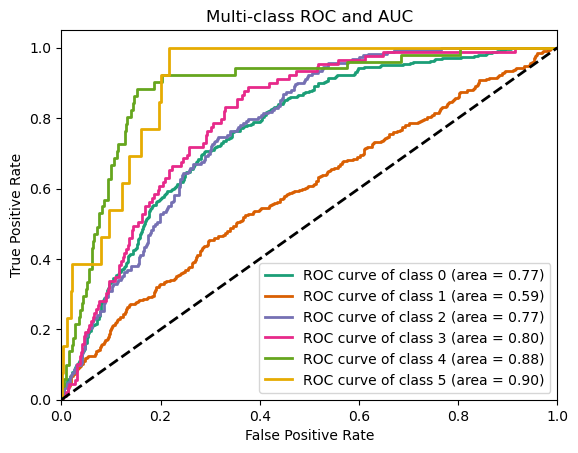

In [34]:
X = adata_mvi.obs[['epxr_latent_0', 'epxr_latent_1', 'epxr_latent_2', 'epxr_latent_3', 'epxr_latent_4', 'epxr_latent_5', 
'epxr_latent_6', 'epxr_latent_7', 'epxr_latent_8', 'epxr_latent_9',  
 'atac_latent_0', 'atac_latent_1', 'atac_latent_2', 'atac_latent_3', 'atac_latent_4', 'atac_latent_5', 
 'atac_latent_6', 'atac_latent_7', 'atac_latent_8', 'atac_latent_9']]
# adata_mvi.obs["latent_time_50"] = pd.cut(adata_mvi.obs['latent_time'], 50, labels=[i for i in range(50)])
# adata_mvi.obs["latent_time_10"] = pd.cut(adata_mvi.obs['latent_time'], 10, labels=[i for i in range(10)])
# adata_mvi.obs["latent_time_5"] = pd.cut(adata_mvi.obs['latent_time'], 5, labels=[i for i in range(5)])
# adata_mvi.obs["latent_time_8"] = pd.cut(adata_mvi.obs['latent_time'], 8, labels=[str(i) for i in range(8)])
# adata_mvi.obs["latent_time_6"] = pd.cut(adata_mvi.obs['latent_time'], 6, labels=[str(i) for i in range(6)])
bins = 6
y = pd.cut(adata_mvi.obs['latent_time'], bins, labels=[i for i in range(bins)])
y = label_binarize(y, classes=range(bins))
n_classes = y.shape[1]
print(n_classes)
#split the dataset into training (70%) and testing (30%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0) 

#instantiate the model
classifier = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=1000))
classifier.fit(X_train, y_train)

#fit the model using the training data
y_score = classifier.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = sns.color_palette("Dark2")
# colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC and AUC')
plt.legend(loc="lower right")
roc_df_temp = pd.DataFrame({"fpr":fpr, "tpr": tpr, "roc_auc":roc_auc, "methods": "couple_halo"})
roc_df = pd.concat([roc_df, roc_df_temp], axis=0)
plt.savefig("figs/Hair/20_aligned/expr_atac_coupled_roc.pdf", dpi=300)

In [36]:
roc_df.to_csv("hair_halo_roc.csv")